In [121]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [122]:
import tensorflow as tf

In [123]:
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

import scipy.ndimage as nd
import random
import datetime
import os
import pickle

In [124]:
# for convering images to a numpy array
def img_to_numpy(img_path, max_dim=None):
    image_path = img_path
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)


In [125]:
# deprocess will allow us to normalize the image in the deep dream function
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [126]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [127]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
              # This needs gradients relative to `img`
              # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [128]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled


In [129]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    
    def __call__(self, img, tile_size=512):
        shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
            # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)

            # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients 


In [130]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(0, 1), octave_scale=1.2):
    
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))
    
    result = deprocess(img)
    base_shape = tf.shape(result)[:-1]

    resize_img = tf.image.resize(result, base_shape)
    dtype_img = tf.image.convert_image_dtype(resize_img/255.0, dtype=tf.uint8)
    # show(result)
    
    np_image = np.array(dtype_img)
    final_image = PIL.Image.fromarray(np_image)

    return final_image


In [131]:
# translate values from one number range to a new range
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin
    valueScaled = float(value - leftMin) / float(leftSpan)
    
    return round(rightMin + (valueScaled * rightSpan))


In [132]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [133]:
# list of all the convolutional layers
names = ['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9', 'mixed10']
layers = [base_model.get_layer(name).output for name in names]

# print(layers[5][:,:,:,40:50])

In [134]:
path, dirs, files = next(os.walk("./data/"))
file_name = path + files[1]

frame = img_to_numpy(file_name, max_dim=800)
h, w = frame.shape[:2]
s = 0.05

# using this to keep track of how many times we've called the deep dream function
recursive_layer = 0


In [135]:
# load our progress from save_state.pickle if no pickle file exists create a new one 
# this allows us to resume our progress/start at the image we were last on
pickle_exists = os.path.isfile('save_state.pickle')

if pickle_exists == True:
    print("loading pickle...")
    with open("save_state.pickle", 'rb') as pickle_file:
        recursive_layer = pickle.load(pickle_file)
        frame = pickle.load(pickle_file)
else:
    print("creating new pickle...")
    with open("save_state.pickle", "wb") as pickle_file:
        pickle.dump(recursive_layer, pickle_file)
        pickle.dump(frame, pickle_file)


loading pickle...


In [136]:
# creating folder for our dreamed images
dream_data_exists = os.path.exists('dream_data')

if dream_data_exists != True:
    os.makedirs('dream_data')
    print("creating dream_data folder")


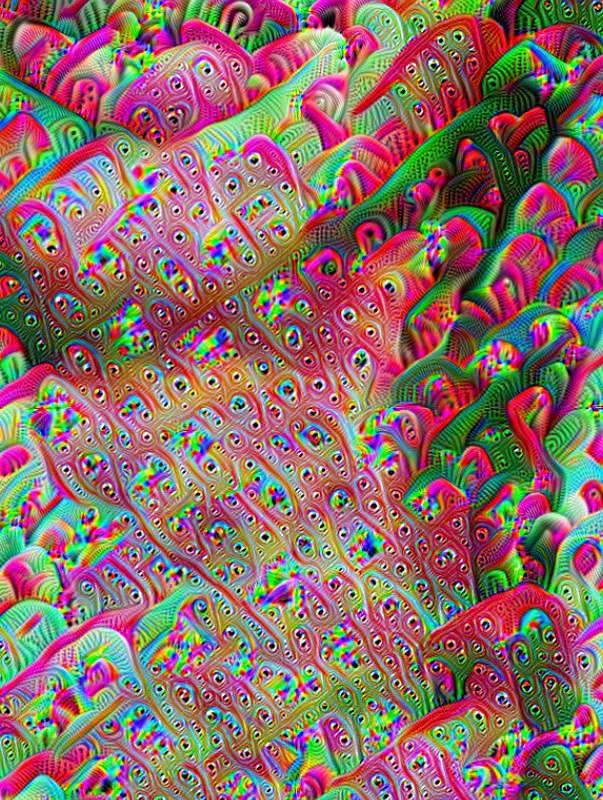

Octave 0, Step 0


KeyboardInterrupt: 

In [137]:
while True:
    # saving the last deep dream image and recursive layer we were 
    # on into pickle file so we don't lose our progress
    with open("save_state.pickle", "wb") as pickle_file:
        pickle.dump(recursive_layer, pickle_file)
        pickle.dump(frame, pickle_file)
    
    # we can use the number of recursive steps we have taken to index 
    # which layer we should optimize, this will give us a nice even 
    # spread of every convolutional layer in our dream images
    layer_number = translate(recursive_layer, 0, 500, 0, 10)
    print("layer_number", layer_number)

    # load models and select layers to optimize 
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers[layer_number])
    deepdream = DeepDream(dream_model)
    get_tiled_gradients = TiledGradients(dream_model)

    # call deep dream function recursively and save progress
    frame = run_deep_dream_with_octaves(img=frame, step_size=0.01)
    frame.save('./dream_data/dream_frame_' + str(recursive_layer) + '.jpg')
    
    # scaling image for next iteration this way it continues to find new features
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    
    recursive_layer += 1
    if recursive_layer == 501:
        break
    
    
print("done!")
